Cutting the MH budget method refers to Korattikara's 2014 paper

Adaptive MH method refers to Bardenet's 2014 paper

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.stats import t
from bisect import bisect
import scipy.io
from scipy.stats import norm
import numpy.matlib
%matplotlib inline
import h5py

np.set_printoptions(edgeitems=100)

UPDATE October 10, 2016
This cell is outdated. It refers to our older MH Test on the regular MNIST data.

Logistic Regression Test Result

test parameters: nsamps = 5000, minibatchsize = 100, sigma_proposer = 0.05, number of data points = 12007, temperature = 1000.0, cutmh method error bournd = 0.005



UPDATE Here are the new parameters:
- number of samples 3000
- starting minibatch size (and mb "increment" amount) 100
- sigma proposer 0.05
- number of data points 16000 in training, 4000 in testing (20000 total)
- temperature 200
- Korattikara tolerance epsilon = 0.005
- Bardenet p = 2.0
- Bardenet delta = 0.01
- Bardenet gamma = 1.5

970


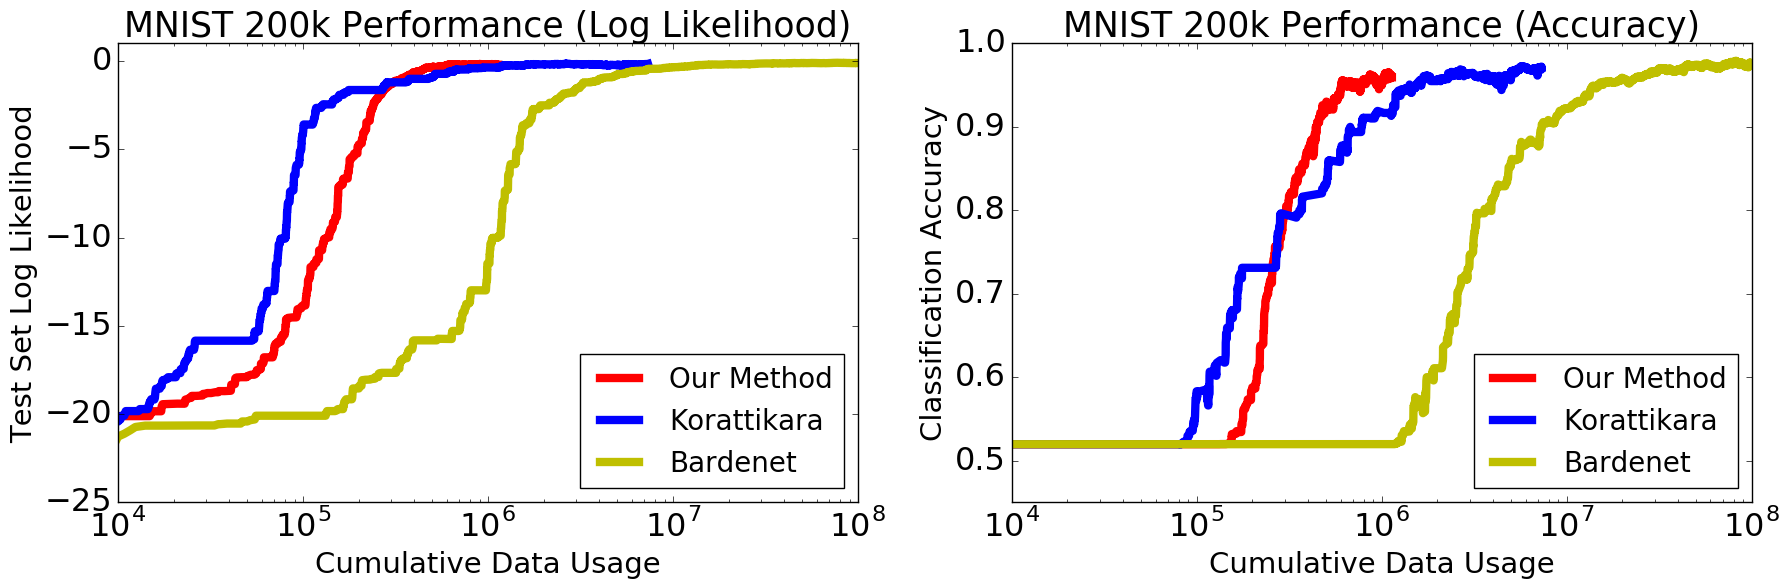

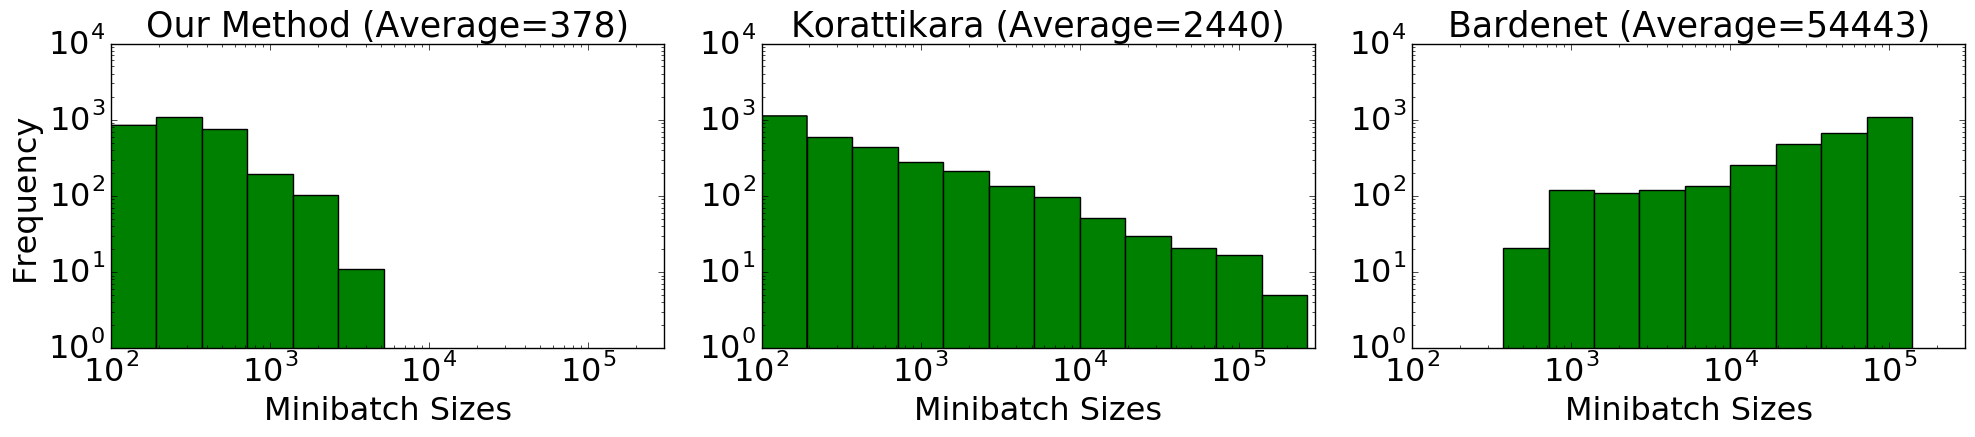

In [27]:
# Note: let's keep *everything* here.

#############
### FILES ###
#############

di = "final_output/"
DPI = 300
K = "200000"
N = 3000

df_ours = h5py.File(di+ 'logistic_results_ours_' +K+ '.mat');
df_kora = h5py.File(di+ 'logistic_results_kora_' +K+ '_eps0-05.mat');
df_bard_s = h5py.File(di+ 'logistic_results_bard_' +K+ '_samples.mat')
df_bard_t = h5py.File(di+ 'logistic_results_bard_' +K+ '_test.mat')

samples_ours  = np.array(df_ours['samples_ours'])
mb_size_ours  = np.array(df_ours['mb_size_ours']).reshape(N,1)
cum_size_ours = np.array(df_ours['cum_size_ours']).reshape(N,1)
ll_test_ours  = np.array(df_ours['ll_test_ours']).reshape(N,1)
accuracy_ours = np.array(df_ours['accuracy_ours']).reshape(N,1)

samples_kora  = np.array(df_kora['samples_kora'])
mb_size_kora  = np.array(df_kora['mb_size_kora']).reshape(N,1)
cum_size_kora = np.array(df_kora['cum_size_kora']).reshape(N,1)
ll_test_kora  = np.array(df_kora['ll_test_kora']).reshape(N,1)
accuracy_kora = np.array(df_kora['accuracy_kora']).reshape(N,1)

# Note that Xinlei put the Bardenet stuf fin two files.
samples_bard  = np.array(df_bard_s['samples_bard'])
mb_size_bard  = np.array(df_bard_s['mb_size_bard']).reshape(N,1)
cum_size_bard = np.array(df_bard_t['cum_size_bard']).reshape(N,1)
ll_test_bard  = np.array(df_bard_t['ll_test_bard']).reshape(N,1)
accuracy_bard = np.array(df_bard_t['accuracy_bard']).reshape(N,1)
    
assert samples_ours.shape == (N,784)
assert samples_kora.shape == (N,784)
assert samples_bard.shape == (N,784)

num_reject = 0
for i in range(N-1):
    theta_now = samples_bard[i]
    theta_next = samples_bard[i+1]
    if np.max(np.abs(theta_now-theta_next)) < 0.0001:
        num_reject += 1
print(num_reject)
        

###############
### FIGURES ###
###############

fig, axarr = plt.subplots(1,2, figsize=(18, 6))
x_label = "Cumulative Data Usage"
title_size = 25
axis_size = 21
tick_size = 23
legend_size = 20
width = 6.0
xlimits = [(10**4), (10**8)]

axarr[0].plot(cum_size_ours, ll_test_ours, 'r', label='Our Method', lw=width)
axarr[0].plot(cum_size_kora, ll_test_kora, 'b', label='Korattikara', lw=width)
axarr[0].plot(cum_size_bard, ll_test_bard, 'y', label='Bardenet', lw=width)
axarr[0].set_xlim(xlimits)
axarr[0].set_ylim([-25,1])
axarr[0].set_xscale("log")
axarr[0].set_title("MNIST 200k Performance (Log Likelihood)", fontsize=title_size)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel("Test Set Log Likelihood", fontsize=axis_size)
axarr[0].legend(loc="lower right", prop={'size':legend_size})
axarr[0].tick_params(axis='x', labelsize=tick_size)
axarr[0].tick_params(axis='y', labelsize=tick_size)

axarr[1].plot(cum_size_ours, accuracy_ours, 'r', label='Our Method', lw=width)
axarr[1].plot(cum_size_kora, accuracy_kora, 'b', label='Korattikara', lw=width)
axarr[1].plot(cum_size_bard, accuracy_bard, 'y', label='Bardenet', lw=width)
axarr[1].set_xlim(xlimits)
axarr[1].set_ylim([0.45,1])
axarr[1].set_xscale("log")
axarr[1].set_title("MNIST 200k Performance (Accuracy)", fontsize=title_size)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
axarr[1].set_ylabel("Classification Accuracy", fontsize=axis_size)
axarr[1].legend(loc="lower right", prop={'size':legend_size})
axarr[1].tick_params(axis='x', labelsize=tick_size)
axarr[1].tick_params(axis='y', labelsize=tick_size)

plt.tight_layout()
plt.savefig(di+"logistic_regression_ll_acc_results.png", dpi=DPI)



# NEXT FIGURE!
fig, axarr = plt.subplots(1,3, figsize=(20, 4.5))

#A bunch of common values. The max_y value may need some tweaking.
min_x = (10**2)
max_x = (10**5)*3
min_y = 0
max_y = 10000
yaxis_ticks = [1,10,100,1000,10000]
title_size = 25
axis_size = 23
tick_size = 23
fc = 'green'
x_label = "Minibatch Sizes"
y_label = "Frequency"

axarr[0].set_title("Our Method (Average={})".format(int(np.mean(mb_size_ours))), fontsize=title_size)
axarr[0].hist(mb_size_ours, bins=np.logspace(2, 6, 15), facecolor=fc)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel(y_label, fontsize=axis_size)
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim([min_x,max_x])
axarr[0].set_ylim([min_y,max_y])
axarr[0].set_yticks(yaxis_ticks)
axarr[0].tick_params(axis='x', labelsize=tick_size)
axarr[0].tick_params(axis='y', labelsize=tick_size)

axarr[1].set_title("Korattikara (Average={})".format(int(np.mean(mb_size_kora))), fontsize=title_size)
axarr[1].hist(mb_size_kora, bins=np.logspace(2, 6, 15), facecolor=fc)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
#axarr[1].set_ylabel(y_label, fontsize=axis_size)
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlim([min_x,max_x])
axarr[1].set_ylim([min_y,max_y])
axarr[1].set_yticks(yaxis_ticks)
axarr[1].tick_params(axis='x', labelsize=tick_size)
axarr[1].tick_params(axis='y', labelsize=tick_size)

axarr[2].set_title("Bardenet (Average={})".format(int(np.mean(mb_size_bard))), fontsize=title_size)
axarr[2].hist(mb_size_bard, bins=np.logspace(2, 6, 15), facecolor=fc)
axarr[2].set_xlabel(x_label, fontsize=axis_size)
#axarr[2].set_ylabel(y_label, fontsize=axis_size)
axarr[2].set_xscale('log')
axarr[2].set_yscale('log')
axarr[2].set_xlim([min_x,max_x])
axarr[2].set_ylim([min_y,max_y])
axarr[2].set_yticks(yaxis_ticks)
axarr[2].tick_params(axis='x', labelsize=tick_size)
axarr[2].tick_params(axis='y', labelsize=tick_size)

plt.tight_layout()
plt.savefig(di+"logistic_regression_histograms_results.png", dpi=DPI)

In [2]:
"""NEW! Let's re-plot, this time with the revised script to test for larger sizes.

(Mostly written by Daniel, aided by Xinlei's previous template.)
"""

# Let's get the file (df = data file) with all the matrices inside it.
df_ours = h5py.File('output/logistic_results_ours_20000.mat');
df_kora = h5py.File('output/logistic_results_kora_20000_eps0005_.mat');
df_bard = h5py.File('output/logistic_results_bard_20000.mat');
N = 3000

# The actual "theta" samples.
samples_ours = np.array(df_ours['samples_ours'])
samples_kora = np.array(df_kora['samples_kora'])
samples_bard = np.array(df_bard['samples_bard'])

# The cumulative MB sizes.
cum_size_ours = np.array(df_ours['cum_size_ours'])
cum_size_kora = np.array(df_kora['cum_size_kora'])
cum_size_bard = np.array(df_bard['cum_size_bard'])

# The per-iteration mini-batch sizes.
mb_size_ours = np.array(df_ours['mb_size_ours'])
mb_size_kora = np.array(df_kora['mb_size_kora'])
mb_size_bard = np.array(df_bard['mb_size_bard'])

# LL on training set
ll_train_ours = np.array(df_ours['ll_train_ours'])
ll_train_kora = np.array(df_kora['ll_train_kora'])
ll_train_bard = np.array(df_bard['ll_train_bard'])

# LL on testing set (we should probably be using this)
ll_test_ours = np.array(df_ours['ll_test_ours']).reshape(N,1)
ll_test_kora = np.array(df_kora['ll_test_kora']).reshape(N,1)
ll_test_bard = np.array(df_bard['ll_test_bard']).reshape(N,1)

# Finally, accuracy!!
accuracy_ours = np.array(df_ours['accuracy_ours']).reshape(N,1)
accuracy_kora = np.array(df_kora['accuracy_kora']).reshape(N,1)
accuracy_bard = np.array(df_bard['accuracy_bard']).reshape(N,1)

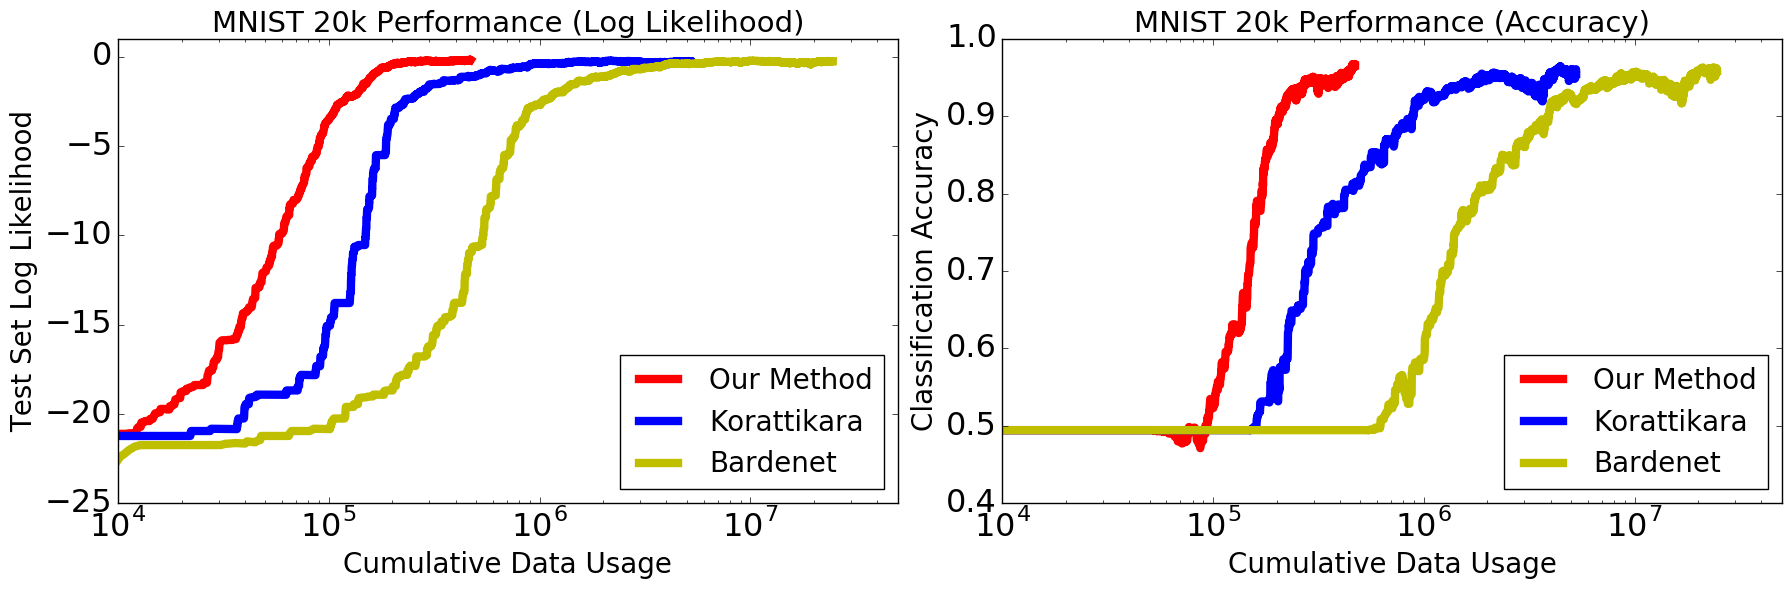

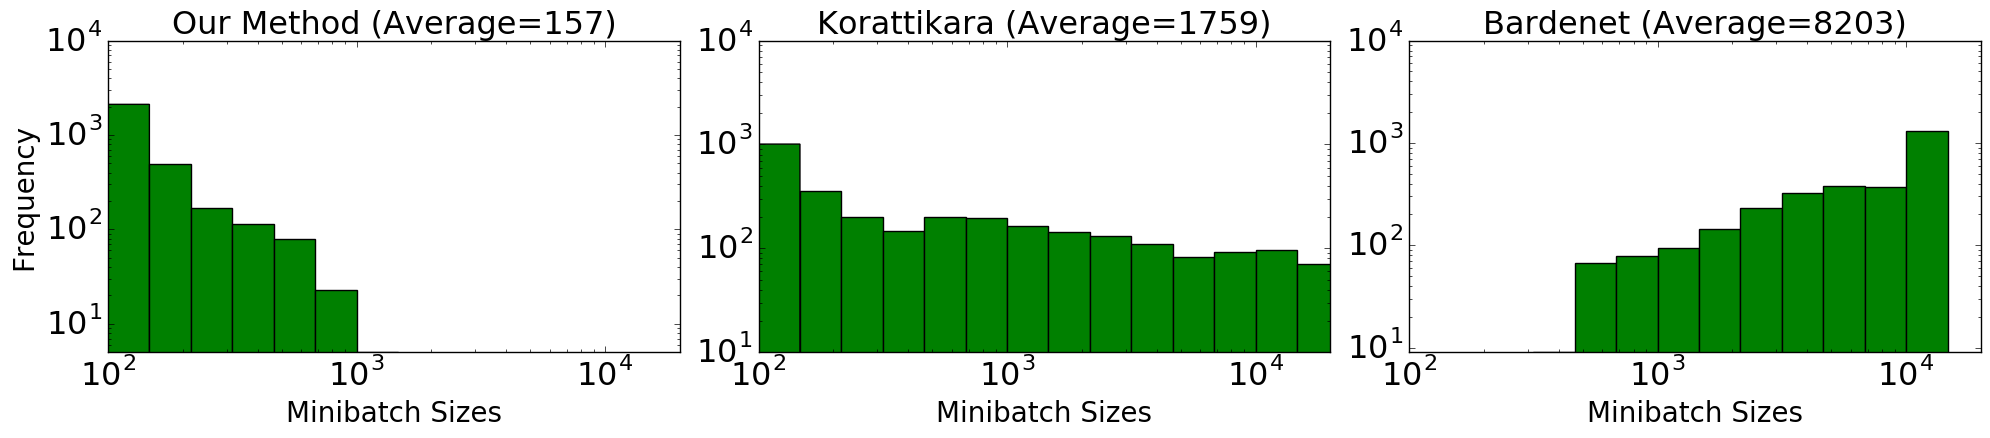

In [3]:
"""
Now we can plot the *performance* on Logistic Regression.
Here, we use both log likelihood and accuracy.
And then we'll plot the minibatch sizes.
"""

#Let's get the plot and some shared values established.
import matplotlib
fig, axarr = plt.subplots(1,2, figsize=(18, 6))

x_label = "Cumulative Data Usage"
title_size = 21
axis_size = 20
tick_size = 23
legend_size = 20
width = 6.0
xlimits = [10**4, (10**8)/2]

axarr[0].plot(cum_size_ours, ll_test_ours, 'r', label='Our Method', lw=width)
axarr[0].plot(cum_size_kora, ll_test_kora, 'b', label='Korattikara', lw=width)
axarr[0].plot(cum_size_bard, ll_test_bard, 'y', label='Bardenet', lw=width)
axarr[0].set_xlim(xlimits)
axarr[0].set_ylim([-25,1])
axarr[0].set_xscale("log")
axarr[0].set_title("MNIST 20k Performance (Log Likelihood)", fontsize=title_size)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel("Test Set Log Likelihood", fontsize=axis_size)
axarr[0].legend(loc="lower right", prop={'size':legend_size})
axarr[0].tick_params(axis='x', labelsize=tick_size)
axarr[0].tick_params(axis='y', labelsize=tick_size)

axarr[1].plot(cum_size_ours, accuracy_ours, 'r', label='Our Method', lw=width)
axarr[1].plot(cum_size_kora, accuracy_kora, 'b', label='Korattikara', lw=width)
axarr[1].plot(cum_size_bard, accuracy_bard, 'y', label='Bardenet', lw=width)
axarr[1].set_xlim(xlimits)
#axarr[1].set_ylim([0.4,1])
axarr[1].set_xscale("log")
axarr[1].set_title("MNIST 20k Performance (Accuracy)", fontsize=title_size)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
axarr[1].set_ylabel("Classification Accuracy", fontsize=axis_size)
axarr[1].legend(loc="lower right", prop={'size':legend_size})
axarr[1].tick_params(axis='x', labelsize=tick_size)
axarr[1].tick_params(axis='y', labelsize=tick_size)

plt.tight_layout()
#plt.savefig('../figures/LogisticRegressionResult/logistic_performance.png', dpi=300)



# NEXT FIGURE!
fig, axarr = plt.subplots(1,3, figsize=(20, 4.5))

#A bunch of common values. The max_y value may need some tweaking.
min_x = 10**2
max_x = 2*(10**4)
min_y = 0
max_y = 10000
yaxis_ticks = [10,100,1000,10000]
title_size = 23
axis_size = 20
tick_size = 23
fc = 'green'
x_label = "Minibatch Sizes"
y_label = "Frequency"

axarr[0].set_title("Our Method (Average={})".format(int(np.mean(mb_size_ours))), fontsize=title_size)
axarr[0].hist(mb_size_ours, bins=np.logspace(2, 6, 25), facecolor=fc)
axarr[0].set_xlabel(x_label, fontsize=axis_size)
axarr[0].set_ylabel(y_label, fontsize=axis_size)
axarr[0].set_xscale('log')
axarr[0].set_yscale('log')
axarr[0].set_xlim([min_x,max_x])
axarr[0].set_ylim([min_y,max_y])
axarr[0].set_yticks(yaxis_ticks)
axarr[0].tick_params(axis='x', labelsize=tick_size)
axarr[0].tick_params(axis='y', labelsize=tick_size)

axarr[1].set_title("Korattikara (Average={})".format(int(np.mean(mb_size_kora))), fontsize=title_size)
axarr[1].hist(mb_size_kora, bins=np.logspace(2, 6, 25), facecolor=fc)
axarr[1].set_xlabel(x_label, fontsize=axis_size)
#axarr[1].set_ylabel(y_label, fontsize=axis_size)
axarr[1].set_xscale('log')
axarr[1].set_yscale('log')
axarr[1].set_xlim([min_x,max_x])
axarr[1].set_ylim([min_y,max_y])
axarr[1].set_yticks(yaxis_ticks)
axarr[1].tick_params(axis='x', labelsize=tick_size)
axarr[1].tick_params(axis='y', labelsize=tick_size)

axarr[2].set_title("Bardenet (Average={})".format(int(np.mean(mb_size_bard))), fontsize=title_size)
axarr[2].hist(mb_size_bard, bins=np.logspace(2, 6, 25), facecolor=fc)
axarr[2].set_xlabel(x_label, fontsize=axis_size)
#axarr[2].set_ylabel(y_label, fontsize=axis_size)
axarr[2].set_xscale('log')
axarr[2].set_yscale('log')
axarr[2].set_xlim([min_x,max_x])
axarr[2].set_ylim([min_y,max_y])
axarr[2].set_yticks(yaxis_ticks)
axarr[2].tick_params(axis='x', labelsize=tick_size)
axarr[2].tick_params(axis='y', labelsize=tick_size)

plt.tight_layout()
#plt.savefig('../figures/LogisticRegressionResult/minibatch_size_logistic.png', dpi=300)

T=200, average minibatch sizes:
1588.46666667
752.3
450.866666667
100.0
100.0

Now T=20, average minibatch sizes:
957.733333333
100.0
100.0

Now T=1, average minibatch sizes:
1236.6
100.0
100.0

size of samples_kora_10_t01 = (3000, 784)
Accept rate for eps=1.0: 1405/3000


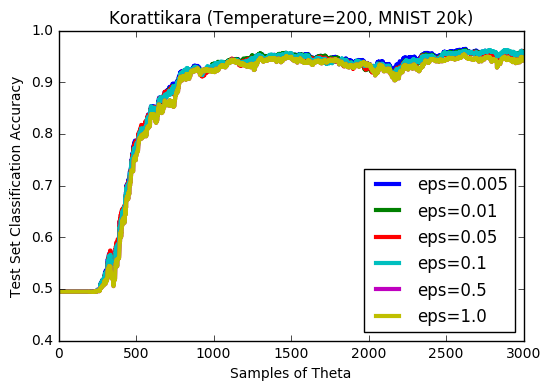

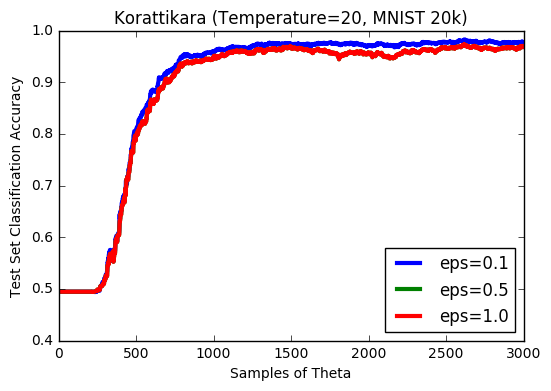

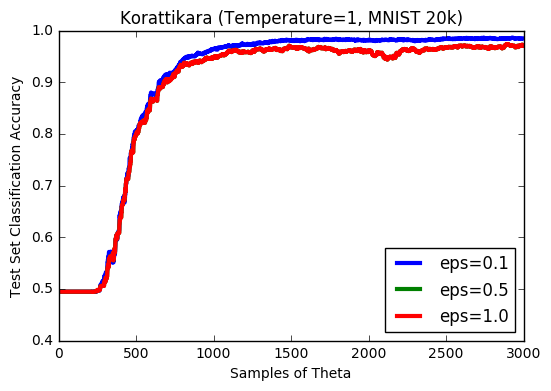

In [4]:
""" Let's analyze what happens when we vary the epsilon tolerance for Korattikara.
"""
N = 3000

# Temperature is T=200
df_kora_0005 = h5py.File('output/logistic_results_kora_20000_eps0005_.mat');
df_kora_001 = h5py.File('output/logistic_results_kora_20000_eps001_.mat');
df_kora_005 = h5py.File('output/logistic_results_kora_20000_eps005_.mat');
df_kora_01 = h5py.File('output/logistic_results_kora_20000_eps01_.mat');
df_kora_05 = h5py.File('output/logistic_results_kora_20000_eps05_.mat');
df_kora_10 = h5py.File('output/logistic_results_kora_20000_eps10_.mat');

# Smaller temperature T=20:
df_kora_01_t20 = h5py.File('output/logistic_results_kora_20000_eps01_temp20.mat');
df_kora_05_t20 = h5py.File('output/logistic_results_kora_20000_eps05_temp20.mat');
df_kora_10_t20 = h5py.File('output/logistic_results_kora_20000_eps10_temp20.mat');

# Even smaller temperature T=1:
df_kora_01_t01 = h5py.File('output/logistic_results_kora_20000_eps01_temp01.mat');
df_kora_05_t01 = h5py.File('output/logistic_results_kora_20000_eps05_temp01.mat');
df_kora_10_t01 = h5py.File('output/logistic_results_kora_20000_eps10_temp01.mat');

# Now the corresopnding accuracy files. T=200:
accuracy_kora_0005 = np.array(df_kora_0005['accuracy_kora']).reshape(N,1)
accuracy_kora_001 = np.array(df_kora_001['accuracy_kora']).reshape(N,1)
accuracy_kora_005 = np.array(df_kora_005['accuracy_kora']).reshape(N,1)
accuracy_kora_01 = np.array(df_kora_01['accuracy_kora']).reshape(N,1)
accuracy_kora_05 = np.array(df_kora_05['accuracy_kora']).reshape(N,1)
accuracy_kora_10 = np.array(df_kora_10['accuracy_kora']).reshape(N,1)

# Then for T=20:
accuracy_kora_01_t20 = np.array(df_kora_01_t20['accuracy_kora']).reshape(N,1)
accuracy_kora_05_t20 = np.array(df_kora_05_t20['accuracy_kora']).reshape(N,1)
accuracy_kora_10_t20 = np.array(df_kora_10_t20['accuracy_kora']).reshape(N,1)

# Finally, for T=1
accuracy_kora_01_t01 = np.array(df_kora_01_t01['accuracy_kora']).reshape(N,1)
accuracy_kora_05_t01 = np.array(df_kora_05_t01['accuracy_kora']).reshape(N,1)
accuracy_kora_10_t01 = np.array(df_kora_10_t01['accuracy_kora']).reshape(N,1)

plt.figure()
w = 3.0
plt.title("Korattikara (Temperature=200, MNIST 20k)")
plt.xlabel("Samples of Theta")
plt.ylabel("Test Set Classification Accuracy")
plt.plot(accuracy_kora_0005, lw=w, label="eps=0.005")
plt.plot(accuracy_kora_001, lw=w, label="eps=0.01")
plt.plot(accuracy_kora_005, lw=w, label="eps=0.05")
plt.plot(accuracy_kora_01, lw=w, label="eps=0.1")
plt.plot(accuracy_kora_05, lw=w, label="eps=0.5")
plt.plot(accuracy_kora_10, lw=w, label="eps=1.0")
plt.legend(loc='lower right')

plt.figure()
w = 3.0
plt.title("Korattikara (Temperature=20, MNIST 20k)")
plt.xlabel("Samples of Theta")
plt.ylabel("Test Set Classification Accuracy")
plt.plot(accuracy_kora_01_t20, lw=w, label="eps=0.1")
plt.plot(accuracy_kora_05_t20, lw=w, label="eps=0.5")
plt.plot(accuracy_kora_10_t20, lw=w, label="eps=1.0")
plt.legend(loc='lower right')

plt.figure()
w = 3.0
plt.title("Korattikara (Temperature=1, MNIST 20k)")
plt.xlabel("Samples of Theta")
plt.ylabel("Test Set Classification Accuracy")
plt.plot(accuracy_kora_01_t01, lw=w, label="eps=0.1")
plt.plot(accuracy_kora_05_t01, lw=w, label="eps=0.5")
plt.plot(accuracy_kora_10_t01, lw=w, label="eps=1.0")
plt.legend(loc='lower right')

print("T=200, average minibatch sizes:")
print(np.mean(df_kora_001['mb_size_kora']))
print(np.mean(df_kora_005['mb_size_kora']))
print(np.mean(df_kora_01['mb_size_kora']))
print(np.mean(df_kora_05['mb_size_kora']))
print(np.mean(df_kora_10['mb_size_kora']))
print("\nNow T=20, average minibatch sizes:")
print(np.mean(df_kora_01_t20['mb_size_kora']))
print(np.mean(df_kora_05_t20['mb_size_kora']))
print(np.mean(df_kora_10_t20['mb_size_kora']))
print("\nNow T=1, average minibatch sizes:")
print(np.mean(df_kora_01_t01['mb_size_kora']))
print(np.mean(df_kora_05_t01['mb_size_kora']))
print(np.mean(df_kora_10_t01['mb_size_kora']))
print("")

# Now let's look at acceptance rates.
samples_kora_10_t01 = np.array(df_kora_10_t01['samples_kora'])
print("size of samples_kora_10_t01 = {}".format(samples_kora_10_t01.shape))
total_diff = 0
for i in range(3000-1):
    current_theta = samples_kora_10_t01[i]
    next_theta = samples_kora_10_t01[i+1]
    if (np.max(np.abs(current_theta-next_theta)) > 0.0001):
        total_diff += 1
print("Accept rate for eps=1.0: {}/3000".format(total_diff))

### 